In [1]:
import  os 
imgs  = os.listdir('data')
import  random 
print(imgs)

['train', 'test']


In [2]:
# train = imgs[0:int(0.8*len(imgs))]
# test  = imgs[int(0.8*len(imgs)):]

In [3]:
import  matplotlib.pyplot  as  plt 
import  cv2
import numpy as np 
import  random
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.applications.vgg16 import VGG16
from tensorflow.python.keras.layers import  Input
from tensorflow.python.keras.layers  import  Flatten
from tensorflow.python.keras import layers
import tensorflow  as tf
from tensorflow.python.keras import  Model

/home/aziz/anaconda3/envs/tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/aziz/anaconda3/envs/tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/aziz/anaconda3/envs/tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/aziz/anaconda3/envs/tf1/lib/python3.6/site-packages/ten

In [4]:
IMG_SHAPE = (224, 224)

In [5]:
import  os  
imgs = os.listdir('data/train')

In [6]:
# imgs

In [7]:
# imgs
'data/train/'+imgs[0]

'data/train/002598.jpg'

In [8]:
img  = cv2.imread('data/train/'+imgs[0])
img  = cv2.resize(img, IMG_SHAPE)

In [9]:


def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

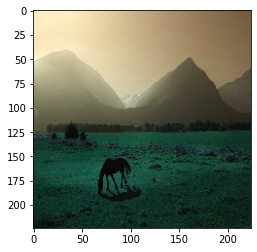

In [10]:
plt.imshow(img)
plt.show()

In [11]:
im_rot  = rotate_image(img, 90)

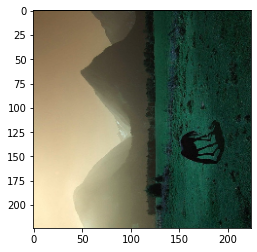

In [12]:
plt.imshow(im_rot)
plt.show()

In [13]:
from scipy import ndimage

#rotation angle in degree
im_rot2 = ndimage.rotate(img, 45)

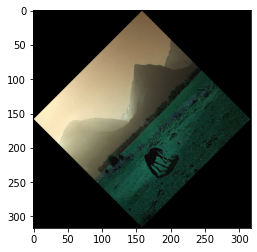

In [14]:
plt.imshow(im_rot2)
plt.show()

In [15]:
from tensorflow.python.keras.applications.vgg16 import VGG16


In [16]:
# def  base_model(input_layer):
#     model = VGG16(weights='imagenet',input_shape=IMG_SHAPE ,include_top=False )(input_layer)
#     model.trainable=False
#     global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
#     feature_batch_average = global_average_layer(model)
#     prediction_layer = tf.keras.layers.Dense(10)(feature_batch_average)
#     return prediction_layer

In [17]:
IMG_SHAPE[:2]+(3,)

(224, 224, 3)

In [18]:
model = VGG16(weights='imagenet',input_shape=IMG_SHAPE[:2]+(3,), include_top=False )
model.trainable=True

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [19]:
ref_image = Input(shape = (IMG_SHAPE+(3,)), name='ref_input')
rot_image = Input(shape = (IMG_SHAPE+(3,)), name='rot_input')

ref   = model(ref_image)
rot   = model(rot_image)

ref   = tf.keras.layers.GlobalAveragePooling2D()(ref)
rot   = tf.keras.layers.GlobalAveragePooling2D()(rot)
                                                 
# ref   = Flatten()(ref )
# rot   = Flatten()(rot )

conc = tf.keras.layers.Concatenate()([ref , rot])

# conc = layers.Dense(512, activation='relu',)(conc)
# conc = layers.Dropout(0.5)(conc)
conc = layers.Dense(64, activation='relu',)(conc)
predict = layers.Dense(1, )(conc)

In [20]:
m = Model(inputs=[ref_image, rot_image],
                      outputs=predict)

In [21]:
m.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ref_input (InputLayer)          [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rot_input (InputLayer)          [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
vgg16 (Model)                   (None, 7, 7, 512)    14714688    ref_input[0][0]                  
                                                                 rot_input[0][0]                  
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 512)          0           vgg16[1][0]                  

In [22]:
# os.listdir('data\\train')

In [23]:
class Batch(tf.keras.utils.Sequence):
    def __init__(self, files,  batchsize,IMG_SHAPE = IMG_SHAPE, base_path = 'data/train/', shuffle = True ):
        self.IMG_SHAPE = IMG_SHAPE
        data = []
        self.files = os.listdir(base_path) 
        for i in range(100):
            for j in self.files:
                
                data.append((j, random.random()))
        self.data   = data 
        self.length = len(data) 
        self.batchsize = batchsize
        self.index     = 0 
        self.base_path = base_path
        
    def __len__(self):
        return len(self.data)//self.batchsize
    
    def ougment(self, image):
        image  = (image  - np.array([123.68, 116.779, 103.939]))/255.0
        return image
        

    def __getitem__(self, index):
        batch_data  = self.data[index*self.batchsize:(index+1)*self.batchsize]
        x1 = []
        x2 = []
        y  = []
        
        for dt  in batch_data: 
#             print(self.base_path+'\\'+dt[0] )
            img  = cv2.imread(self.base_path+'/'+dt[0] )
            
            img  = cv2.resize(img, self.IMG_SHAPE)
            rotate  = dt[1]
            rot = rotate_image(img , rotate*360)
            self.index+=1
            x1.append(self.ougment(img))
            x2.append(self.ougment(rot))
            y.append(dt[1])
            
        return [np.array(x1), np.array(x2)], y
        
        
    def on_epoch_end(self):
        
        data = []
        self.files = os.listdir(self.base_path)
        for i in range(100):
            for j in self.files:
                data.append((j, random.random()))
        self.data   = data
        random.shuffle(self.data)
        print('epoch  has  ended ')


In [24]:
train_batches = Batch([], 64,base_path='data/train/')
test_batches = Batch([], 64,base_path='data/test')

In [25]:
# train_batches.on_epoch_end()
# train_batches.data
# for i in train_batches:
#     print(i)

In [26]:
opt = Adam(lr=5e-5)
m.compile(loss="MSE", optimizer=opt,metrics=["MAE"])

In [27]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,   patience=2, min_lr=1e-5)
mchk=tf.keras.callbacks.ModelCheckpoint( filepath='model/model.h5',  monitor="val_loss", verbose=1,
    save_best_only=True, save_weights_only=True, mode="auto")

In [ ]:
m.fit_generator(
    train_batches, steps_per_epoch=train_batches.length//train_batches.batchsize, epochs=100, verbose=1,  
    validation_data=test_batches, validation_steps=test_batches.length//test_batches.batchsize, 
    class_weight=None, max_queue_size=10,   use_multiprocessing=False,
    callbacks=[mchk,reduce_lr],
)

Epoch 1/100
 35/218 [===>..........................] - ETA: 2:15:12 - loss: 0.1149 - mean_absolute_error: 0.2806

In [ ]:
#  os.listdir('data')

In [ ]:
imtest=cv2.imread('data/train/000008.jpg')

imtest = (imtest  - np.array([123.68, 116.779, 103.939]))/255.0
imtest  = cv2.resize(imtest, IMG_SHAPE)
imtest.shape

In [ ]:
imtest2 = rotate_image(imtest,270)

In [ ]:
m.predict([np.array([imtest,]), np.array([imtest2,])])